# About dataset
Age: age of the patient [years]

Sex: sex of the patient [M: Male, F: Female]

ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]

RestingBP: resting blood pressure [mm Hg]

Cholesterol: serum cholesterol [mm/dl]

FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]

RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]

MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]

ExerciseAngina: exercise-induced angina [Y: Yes, N: No]

Oldpeak: oldpeak = ST [Numeric value measured in depression]

ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

HeartDisease: output class [1: heart disease, 0: Normal]


# Importing Libraries 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from collections import defaultdict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
import joblib

## problem Defintion

- Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of 5CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs and this dataset contains 11 features that can be used to predict a possible heart disease.



- People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

In [2]:
# reading dataset
df=pd.read_csv(r'/kaggle/input/heart-failure-prediction/heart.csv')

In [3]:
df.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
# Shape Of The Dataset
df.shape

(918, 12)

In [5]:
# let’s see if there are null values
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [6]:
# Some info of the Dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


- As we can see the string data in the dataframe is in the form of object, we need to convert it back to string to work on it

In [7]:
string_col = df.select_dtypes(include='object').columns

In [8]:
df[string_col] = df[string_col].astype("string")

In [9]:
df.dtypes

Age                        int64
Sex               string[python]
ChestPainType     string[python]
RestingBP                  int64
Cholesterol                int64
FastingBS                  int64
RestingECG        string[python]
MaxHR                      int64
ExerciseAngina    string[python]
Oldpeak                  float64
ST_Slope          string[python]
HeartDisease               int64
dtype: object

- So, as we can see here the object data has been converted to string

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


- The describe() function in pandas is very handy in getting various summary statistics.This function returns the count, mean, standard deviation, minimum and maximum values and the quantiles of the data.

# Exploratory Data Analysis (EDA)

# Univariate Analysis

In [11]:
# Getting the categorical columns
string_col=df.select_dtypes("string").columns.to_list()

In [12]:
# Getting the numerical columns
num_col=df.columns.to_list()
#print(num_col)
for col in string_col:
    num_col.remove(col)
num_col.remove("HeartDisease")

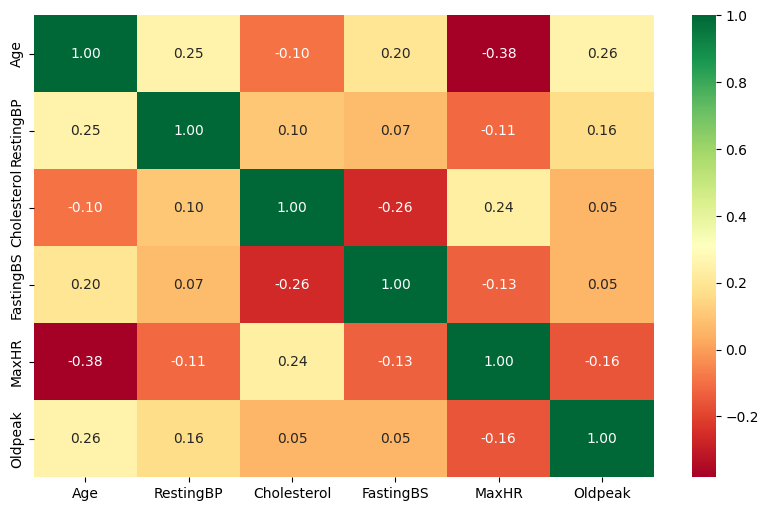

In [13]:
# Correlation numerical features
df_corr = df[num_col].corr()
f, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(df_corr, annot=True, fmt='.2f', cmap='RdYlGn',annot_kws={'size': 10}, ax=ax)
plt.show()

- Here we can see Heart Disease has a high negative correlation with "MaxHR" and somewhat negative correlation wiht "Cholesterol", where as here positive correatlation with "Oldpeak","FastingBS" and "RestingBP

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


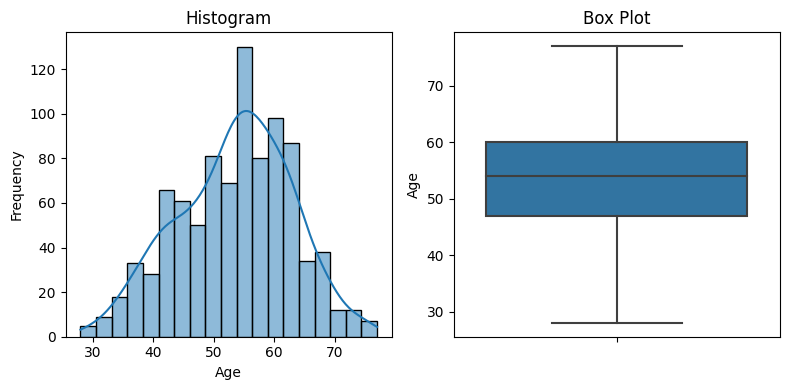

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


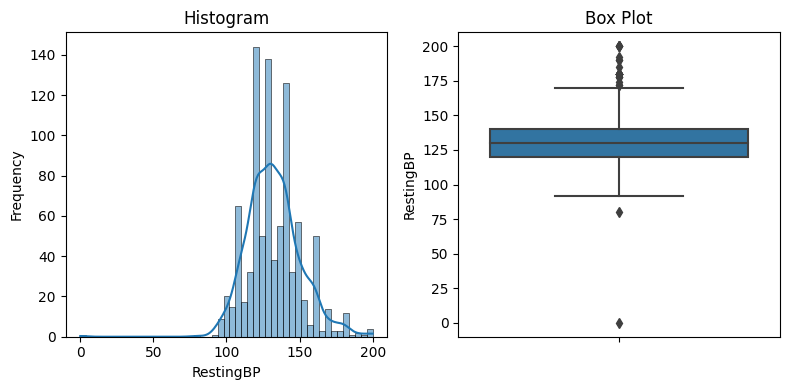

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


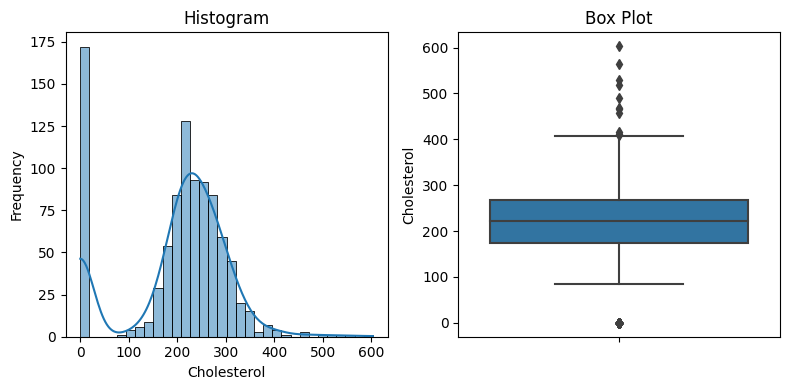

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


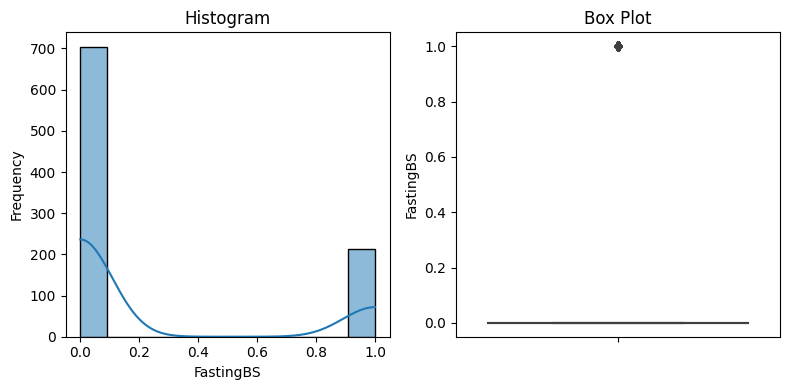

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


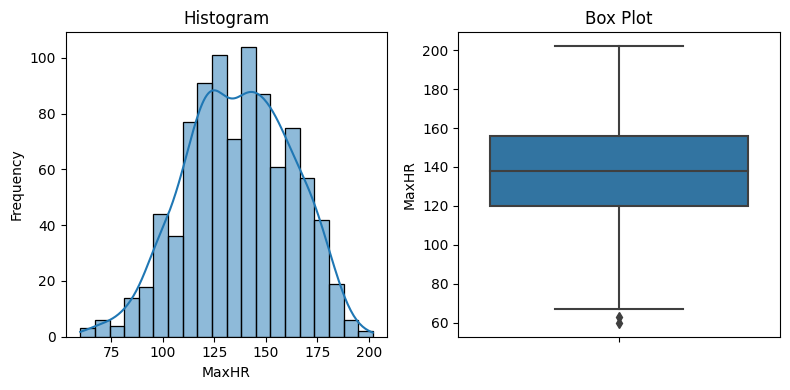

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


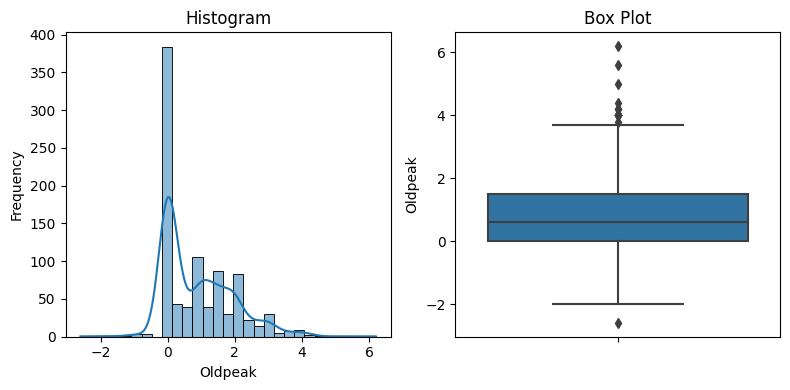

In [14]:
# Perform univariate analysis for each variable
for variable in num_col:
        
    plt.figure(figsize=(8, 4))
    
    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x=variable, kde=True)
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title("Histogram")
    
    # Box plot
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df, y=variable)
    plt.ylabel(variable)
    plt.title("Box Plot")
    
    # Adjust spacing between subplots
    plt.tight_layout()
    
    # Show the plots
    plt.show()

- Oldpeak's data distribution is rightly skewed.
- Cholestrol has a bidmodal data distribution.
- There are too many outliers

Text(0.5, 1.0, 'Bar Plot - HeartDisease')

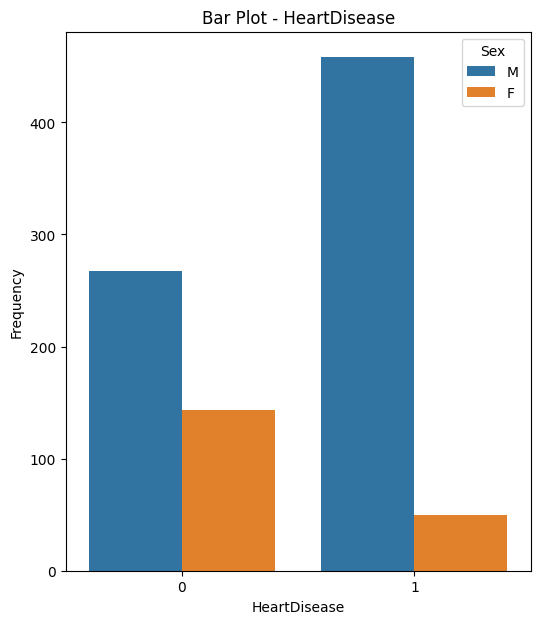

In [15]:
# Perform univariate analysis for HeartDisease
plt.figure(figsize=(6, 7))
sns.countplot(data=df, x="HeartDisease",hue='Sex')
plt.xlabel("HeartDisease")
plt.ylabel("Frequency")
plt.title("Bar Plot - HeartDisease")

Text(0.5, 1.0, 'Bar Plot - HeartDisease')

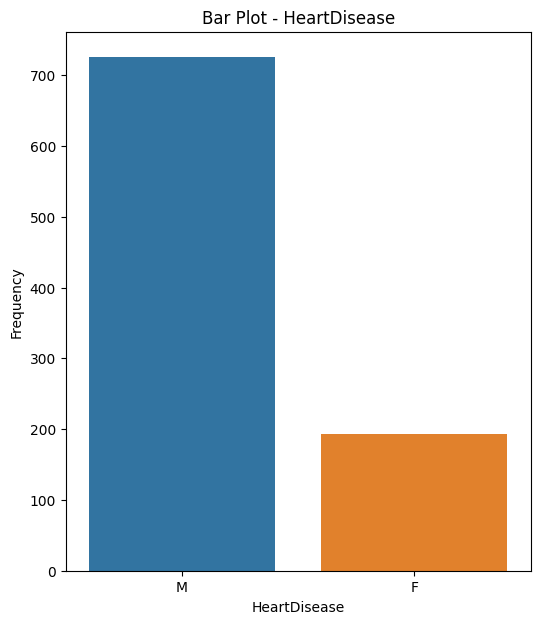

In [16]:
# Perform univariate analysis for HeartDisease
plt.figure(figsize=(6, 7))
sns.countplot(data=df, x="Sex")
plt.xlabel("HeartDisease")
plt.ylabel("Frequency")
plt.title("Bar Plot - HeartDisease")

In [17]:
df['HeartDisease'].value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

- The number of people with heart disease is 508 
- The number of infected men is greater than that of women, because the number of men is greater in the data

Text(0.5, 1.0, 'Bar Plot - ChestPainType')

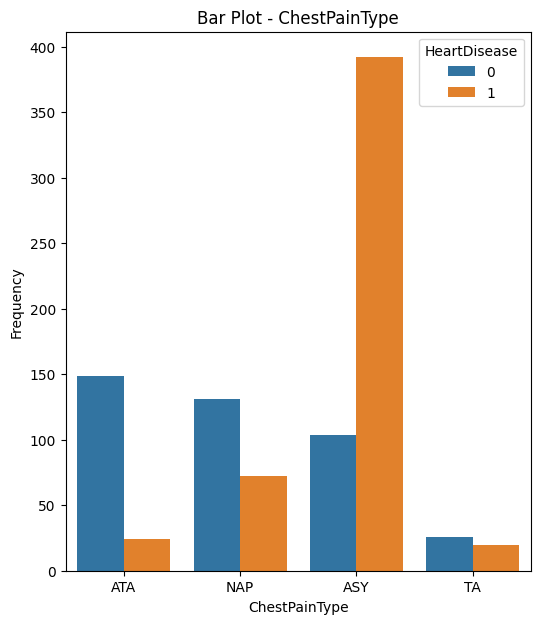

In [18]:
# Perform univariate analysis for ChestPainType
plt.figure(figsize=(6, 7))
sns.countplot(data=df, x="ChestPainType",hue ='HeartDisease')
plt.xlabel("ChestPainType")
plt.ylabel("Frequency")
plt.title("Bar Plot - ChestPainType")

- Most people with heart disease do not feel chest pain !!!

 # Bivariate Analysis

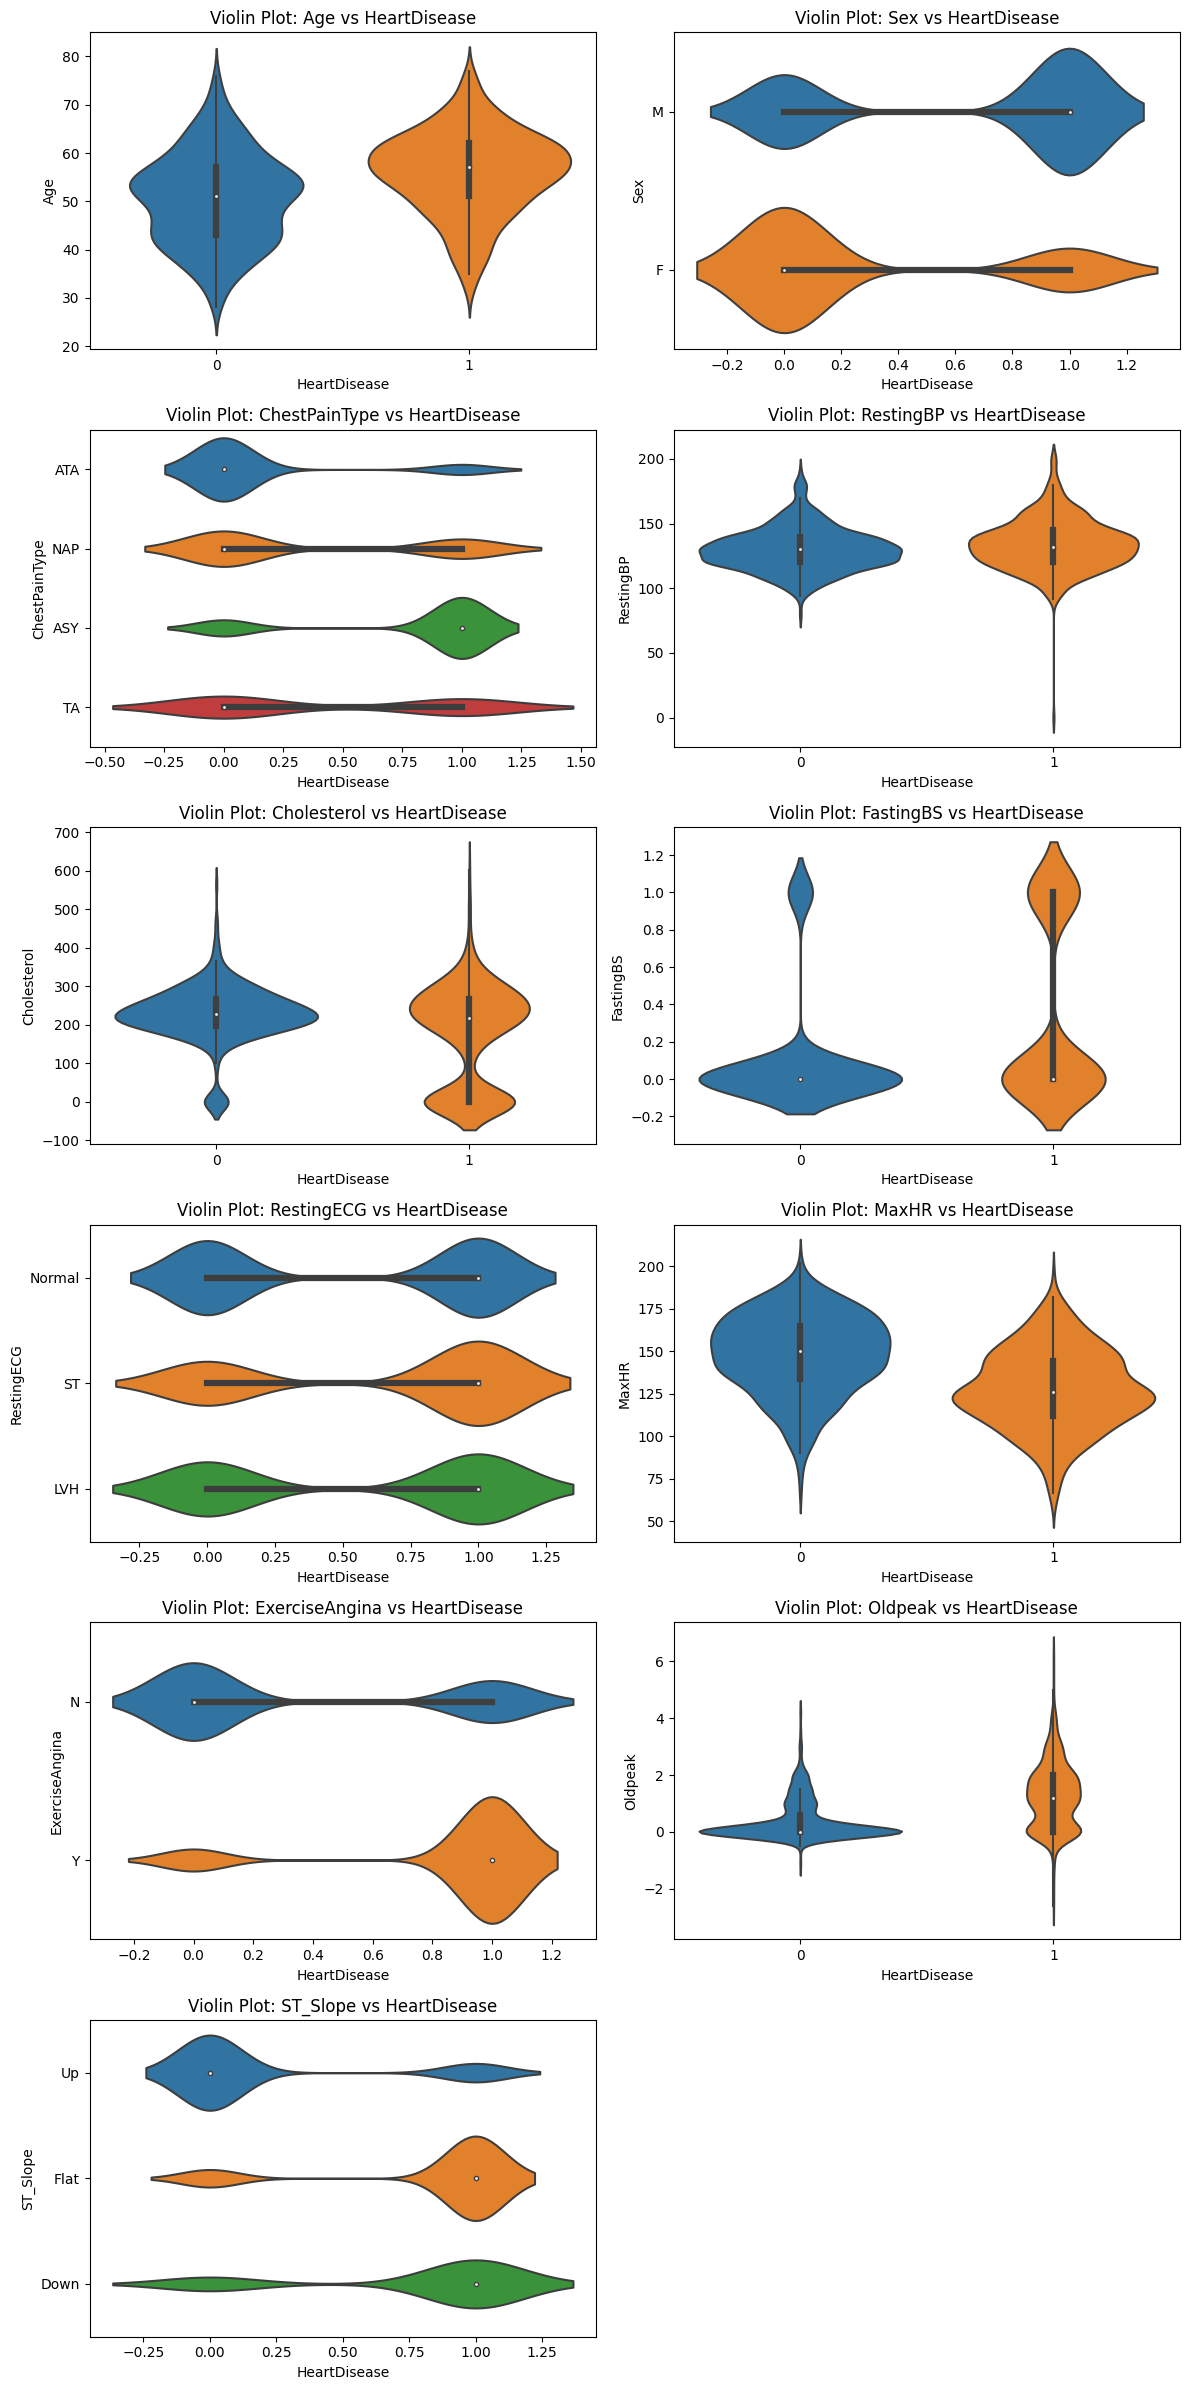

In [19]:
# Get the list of column names except for "HeartDisease"
variables = [col for col in df.columns if col != "HeartDisease"]

# Define the grid layout based on the number of variables
num_variables = len(variables)
num_cols = 2  # Number of columns in the grid
num_rows = (num_variables + num_cols - 1) // num_cols  # Calculate the number of rows needed

# Set the size of the figure
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4*num_rows))

# Generate violin plots for each variable with respect to HeartDisease
for i, variable in enumerate(variables):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row][col]
    
    sns.violinplot(data=df, x="HeartDisease", y=variable, ax=ax)
    ax.set_xlabel("HeartDisease")
    ax.set_ylabel(variable)
    ax.set_title(f"Violin Plot: {variable} vs HeartDisease")
# Remove any empty subplots
if num_variables < num_rows * num_cols:
    for i in range(num_variables, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

- Most people with heart disease are over 50 years old
- ASY type of chest pain dominates other types of chest pain in all the numerical features by a lot.
- Flat, Down and Up in that order display high, middle and low probability of being diagnosed with heart diseases respectively.

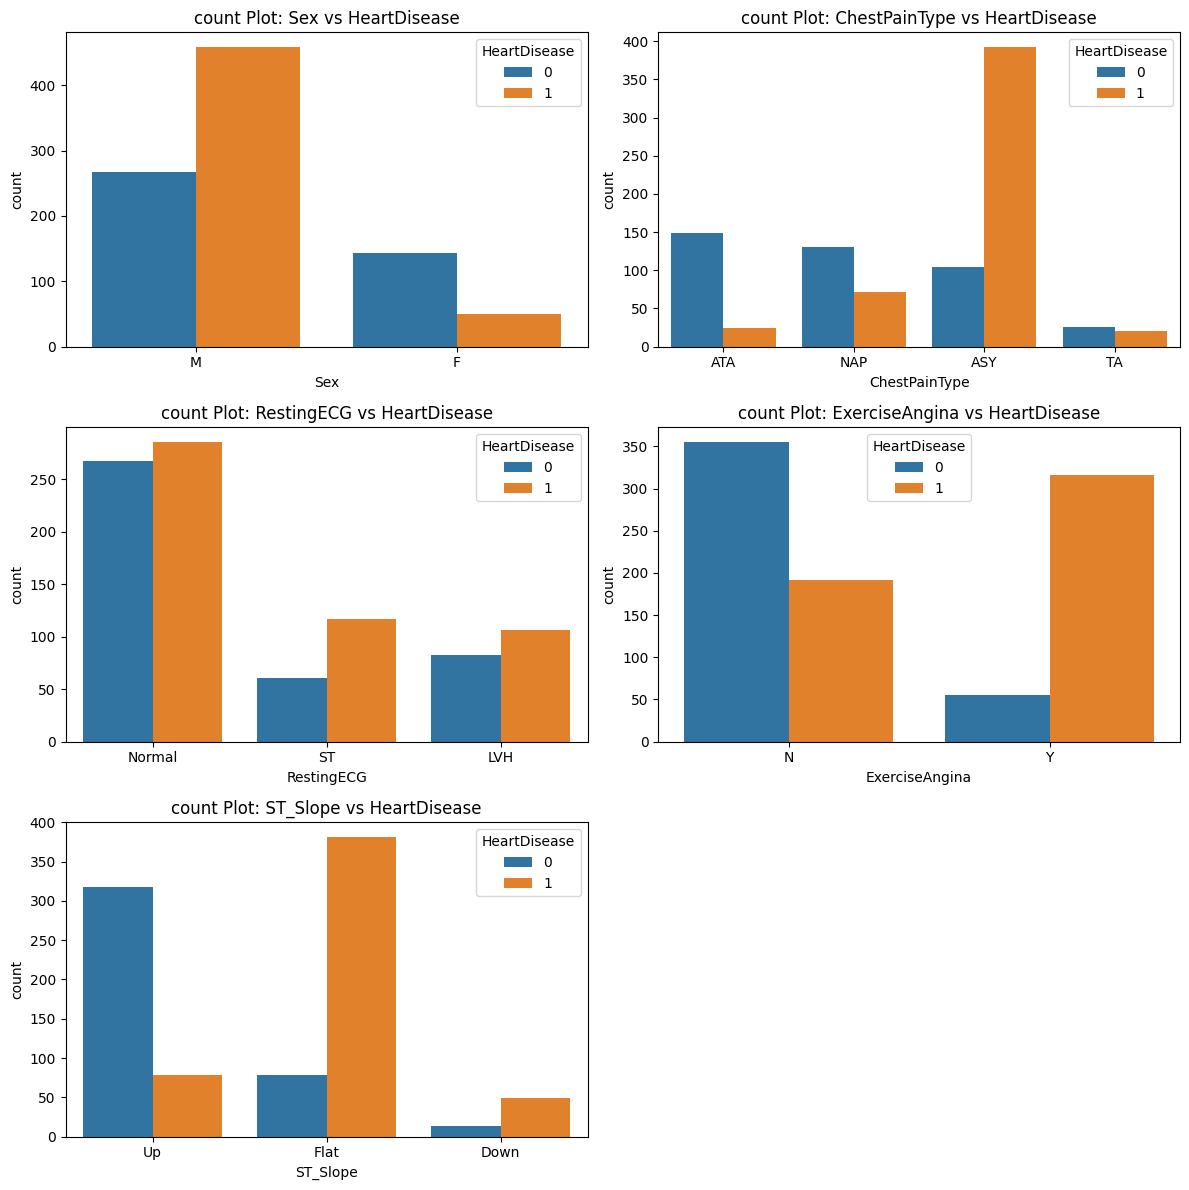

In [20]:
# Define the grid layout based on the number of variables
num_variables = len(string_col)
num_cols = 2  # Number of columns in the grid
num_rows = (num_variables + num_cols - 1) // num_cols  # Calculate the number of rows needed

# Set the size of the figure
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4*num_rows))

# Generate violin plots for each variable with respect to HeartDisease
for i, variable in enumerate(string_col):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row][col]
        
    sns.countplot(data=df, x=variable,hue ='HeartDisease', ax=ax)
    ax.set_xlabel(variable)
    ax.set_ylabel("count")
    ax.set_title(f"count Plot: {variable} vs HeartDisease")

# Remove any empty subplots
if num_variables < num_rows * num_cols:
    for i in range(num_variables, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()



- Male population has more heart disease patients than no heart disease patients. In the case of Female population, heart disease patients are less than no heart disease patients.

- ASY type of chest pain boldly points towards major chances of heart disease.

- Fasting Blood Sugar is tricky! Patients diagnosed with Fasting Blood Sugar and no Fasting Blood Sugar have significant heart disease patients.

- RestingECG does not present with a clear cut category that highlights heart disease patients. All the 3 values consist of high number of heart disease patients.

- Exercise Induced Engina definitely bumps the probability of being diagnosed with heart diseases.

- With the ST_Slope values, flat slope displays a very high probability of being diagnosed with heart disease. Down also shows the same output but in very few data points.

# Feature Engineering (Data Pre-processing)

## Outliers

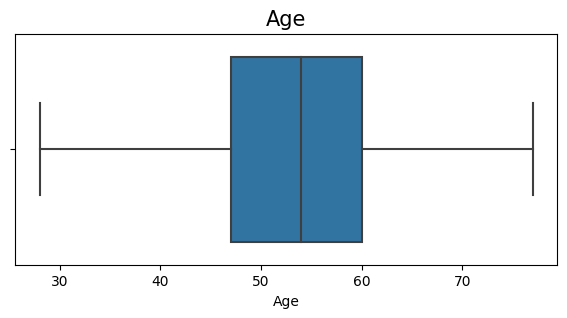

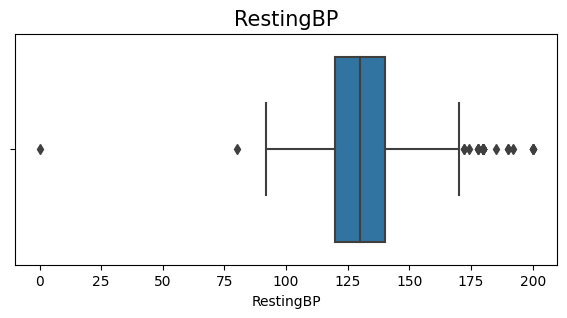

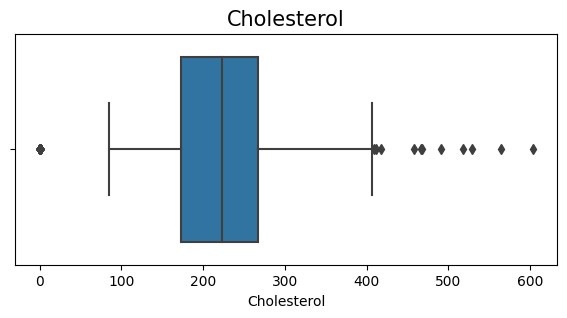

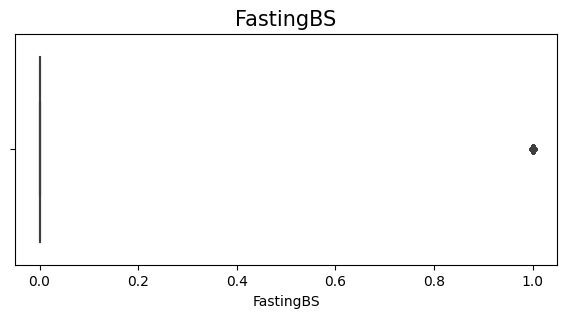

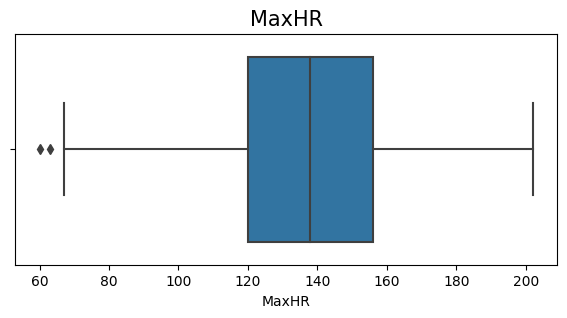

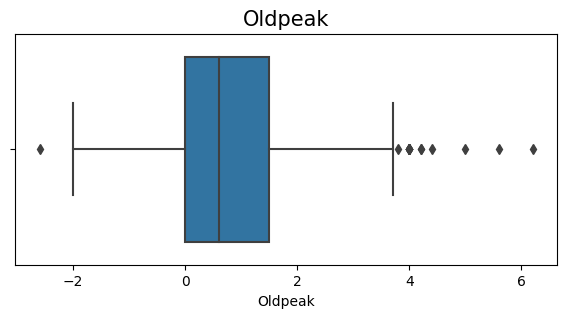

In [21]:
# checking the outliers in each column
for col in num_col:
    
    fig, ax = plt.subplots(figsize=(7, 3))
    
    sns.boxplot(x=df[col], ax=ax)
   
    ax.set_title(col, fontsize=15)

    plt.show()
    


- It appears that the outliers are normal values and cannot be deleted because they may affect the efficiency of the model

# Handling Null Values

- By looking at the “Cholesterol” column, you can see that cholesterol was recorded as “0” for 172 values from the data set which is unreasonable.

- Cholesterol levels cannot be 0. Using “0” values as valid features may result in decreased model performance. Therefore, the number 0 will be replaced by the average cholesterol value for male and female patients.

In [22]:
df['Cholesterol'].value_counts()


Cholesterol
0      172
254     11
223     10
220     10
230      9
      ... 
392      1
316      1
153      1
466      1
131      1
Name: count, Length: 222, dtype: int64

In [23]:
from sklearn.impute import  SimpleImputer

In [24]:
imp = SimpleImputer(missing_values=0)

In [25]:
df['Cholesterol'] = imp.fit_transform(df[['Cholesterol']])

In [26]:
df['Cholesterol'].value_counts()

Cholesterol
244.635389    172
254.000000     11
223.000000     10
220.000000     10
230.000000      9
             ... 
392.000000      1
316.000000      1
153.000000      1
466.000000      1
131.000000      1
Name: count, Length: 222, dtype: int64

## Handling Categorical Variables

In [27]:
# Categorical Variables
df[string_col].head()

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
0,M,ATA,Normal,N,Up
1,F,NAP,Normal,N,Flat
2,M,ATA,ST,N,Up
3,F,ASY,Normal,Y,Flat
4,M,NAP,Normal,N,Up


In [28]:
from sklearn.preprocessing import LabelEncoder

In [29]:
enc = LabelEncoder()

In [30]:
df1= df.copy() 

In [31]:
for col in string_col :
    df1[col]=enc.fit_transform(df1[col])
    

df1 = pd.get_dummies(df,columns=string_col,drop_first=False)

In [32]:
df1 

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289.0,0,1,172,0,0.0,2,0
1,49,0,2,160,180.0,0,1,156,0,1.0,1,1
2,37,1,1,130,283.0,0,2,98,0,0.0,2,0
3,48,0,0,138,214.0,0,1,108,1,1.5,1,1
4,54,1,2,150,195.0,0,1,122,0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,3,110,264.0,0,1,132,0,1.2,1,1
914,68,1,0,144,193.0,1,1,141,0,3.4,1,1
915,57,1,0,130,131.0,0,1,115,1,1.2,1,1
916,57,0,1,130,236.0,0,0,174,0,0.0,1,1


## Data Scaling 

In [33]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [34]:
sc = StandardScaler()
mc = MinMaxScaler()

In [35]:
# MinMaxScaler better for values bettwen 0 and 1 (Oldpeak)
df1['Age'] =  sc.fit_transform(df1[['Age']])
df1['RestingBP'] =  sc.fit_transform(df1[['RestingBP']])
df1['Cholesterol'] = sc.fit_transform(df1[['Cholesterol']])
df1['MaxHR'] =sc.fit_transform(df1[['MaxHR']])
df1['Oldpeak'] =mc.fit_transform(df1[['Oldpeak']])

In [36]:
df1 

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.433140,1,1,0.410909,0.832529,0,1,1.382928,0,0.295455,2,0
1,-0.478484,0,2,1.491752,-1.212922,0,1,0.754157,0,0.409091,1,1
2,-1.751359,1,1,-0.129513,0.719935,0,2,-1.525138,0,0.295455,2,0
3,-0.584556,0,0,0.302825,-0.574892,0,1,-1.132156,1,0.465909,1,1
4,0.051881,1,2,0.951331,-0.931438,0,1,-0.581981,0,0.295455,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,-0.902775,1,3,-1.210356,0.363389,0,1,-0.188999,0,0.431818,1,1
914,1.536902,1,0,0.627078,-0.968969,1,1,0.164684,0,0.681818,1,1
915,0.370100,1,0,-0.129513,-2.132437,0,1,-0.857069,1,0.431818,1,1
916,0.370100,0,1,-0.129513,-0.162048,0,0,1.461525,0,0.295455,1,1


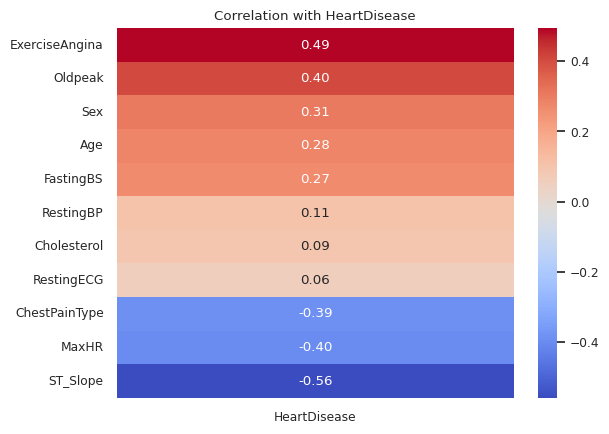

In [37]:
corr = df1.corr()
target_corr = corr['HeartDisease'].drop('HeartDisease')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with HeartDisease')
plt.show()

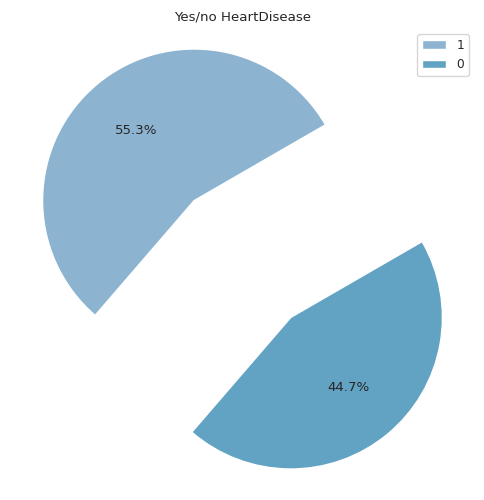

In [38]:
# check the balance of data
def balanced_plot(data):

    plt.figure(figsize=(6, 6))
    plt.pie(df1.HeartDisease.value_counts(), 
            df1.HeartDisease.value_counts().index, 
            autopct='%1.1f%%', 
            startangle=30)
    plt.axis('equal')
    plt.legend(df1.HeartDisease.value_counts().index, loc='best')
    plt.title('Yes/no HeartDisease')
    plt.show()
    
balanced_plot(df1)

## Data Splitting

In [39]:
# Spliting data
X = df1.iloc[:, :-1].values
y = df1.iloc[:, -1].values


In [40]:
# Define preprocessor for NumPy arrays
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [0, 3, 4, 7, 9]),  # column indices for numerical features
        ('cat', OneHotEncoder(), [1, 2, 6, 8, 10])  # column indices for categorical features
    ])

In [41]:
# Define models
models = {
    'LogisticRegression': LogisticRegression(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'SVC': SVC(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'XGBClassifier': XGBClassifier(use_label_encoder=False, eval_metric="error", objective="binary:logistic")
}

# KFold cross-validation for evaluation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary to store results across folds
results = defaultdict(lambda: defaultdict(list))

In [42]:
# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, model_name, fold):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No HeartDisease', 'HeartDisease'],
                yticklabels=['No HeartDisease', 'HeartDisease'])
    plt.title(f"Confusion Matrix for {model_name} (Fold {fold})")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

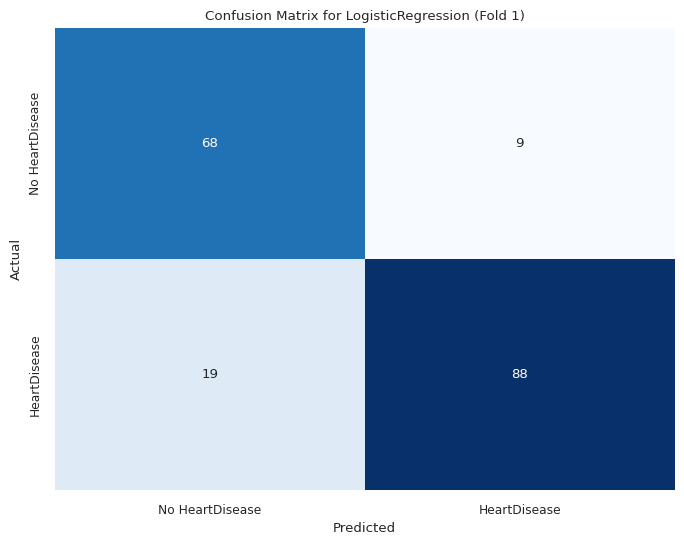

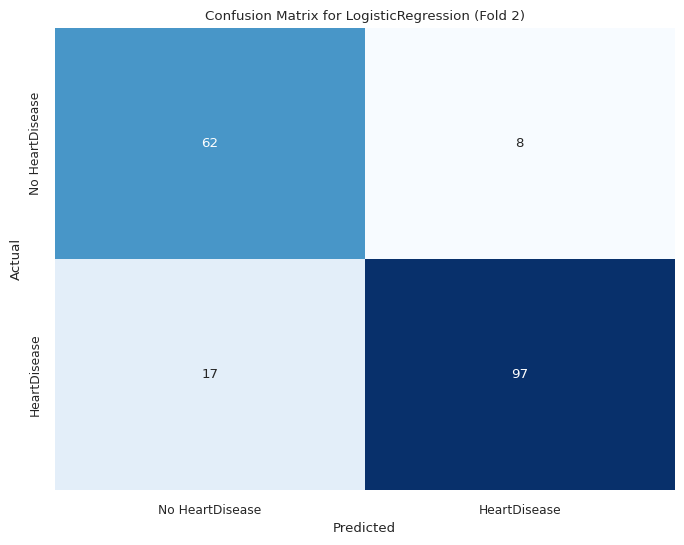

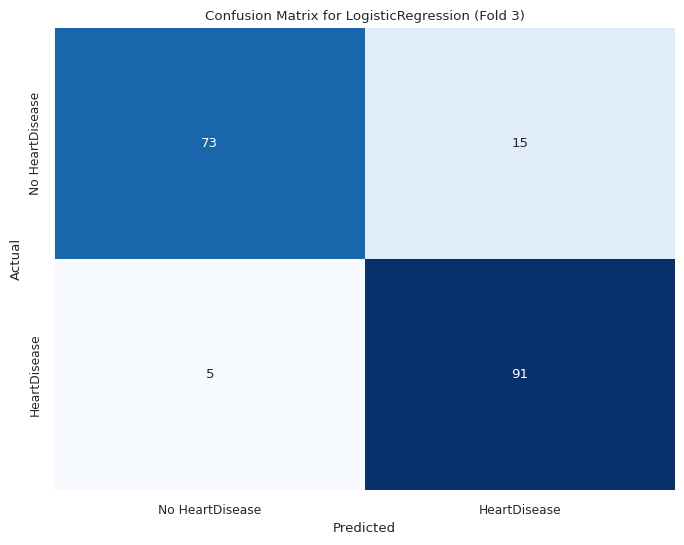

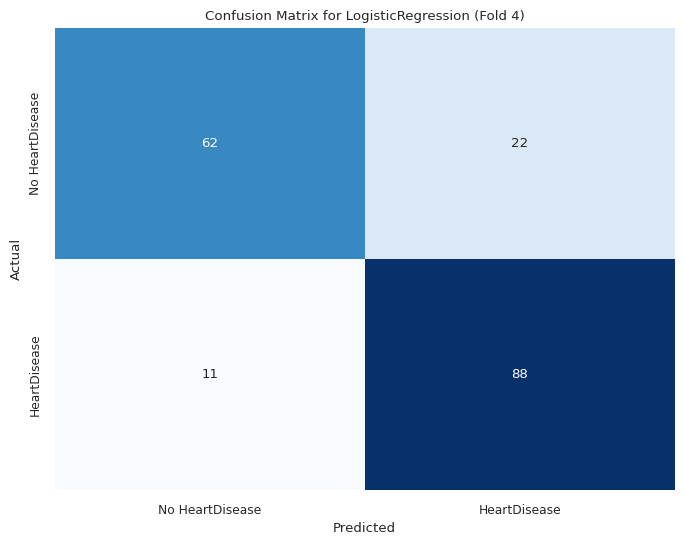

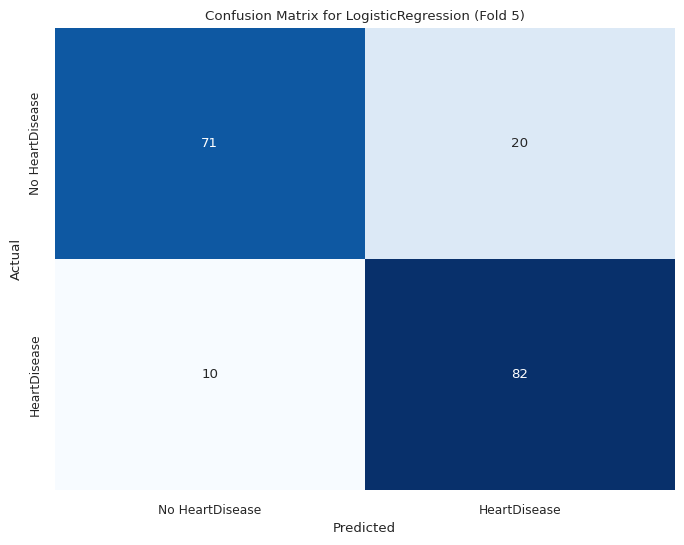

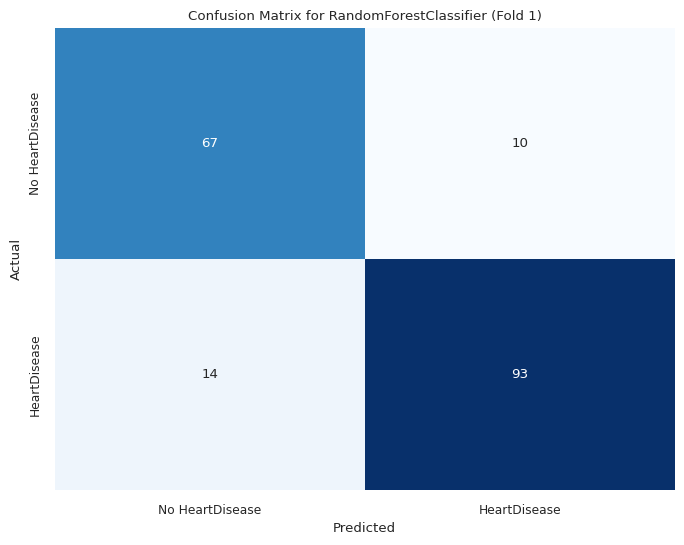

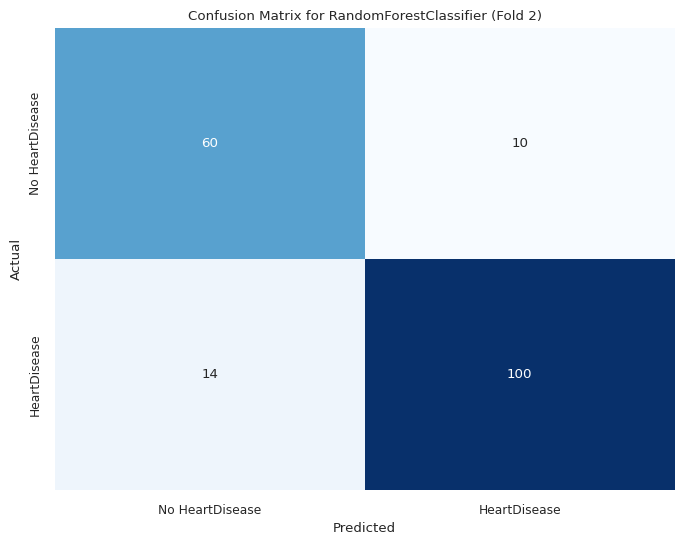

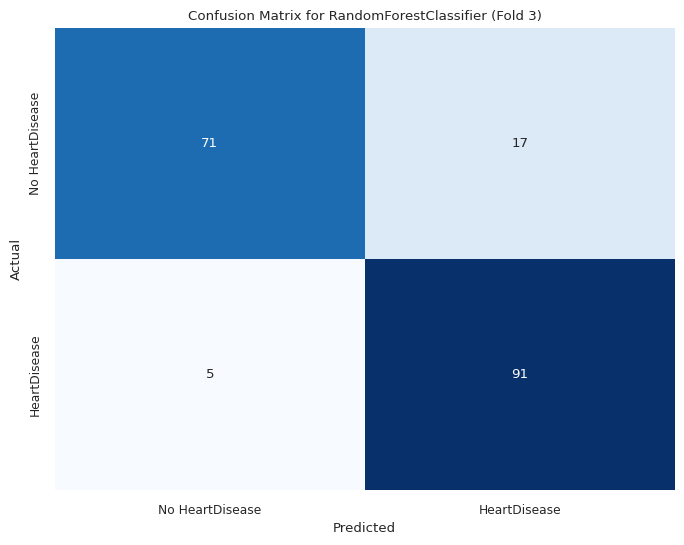

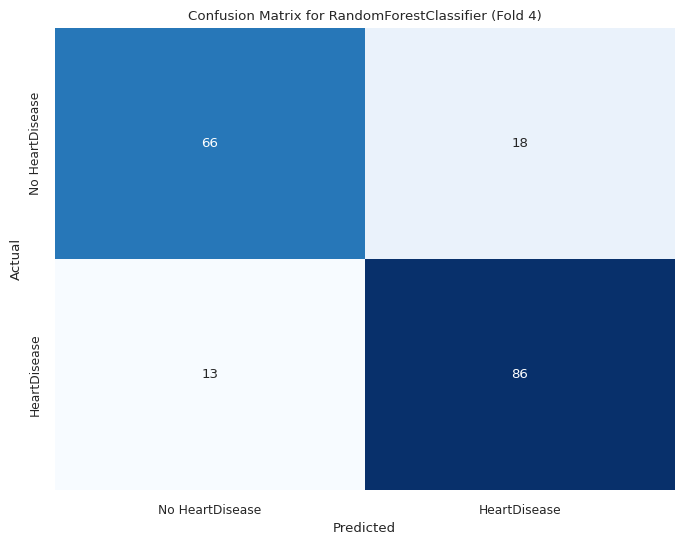

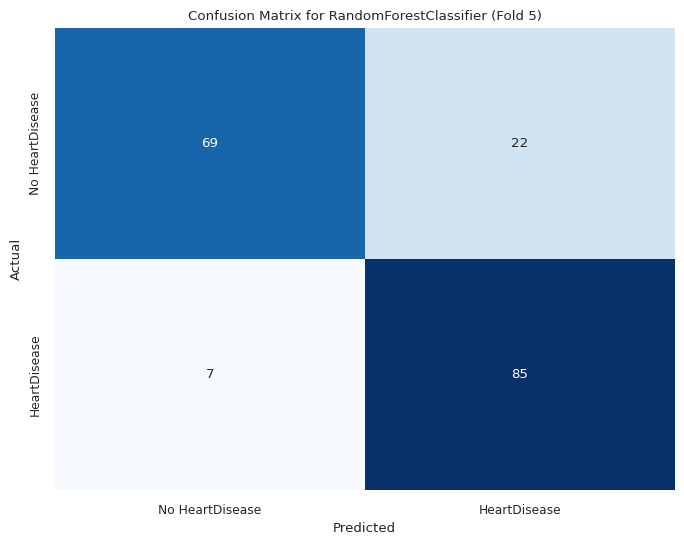

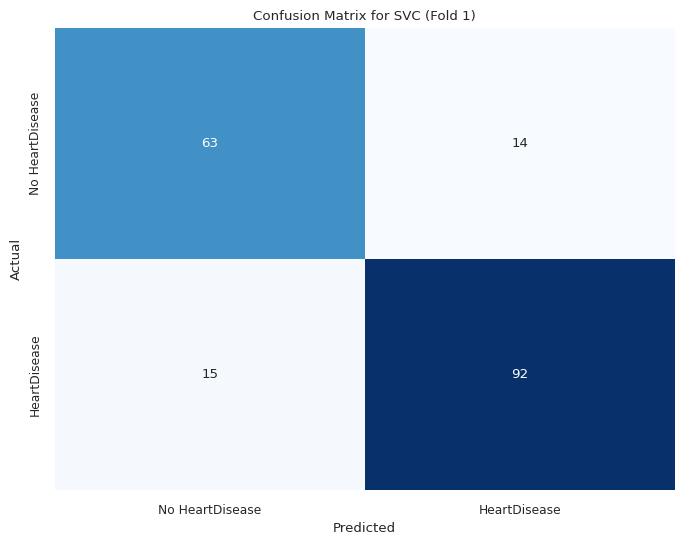

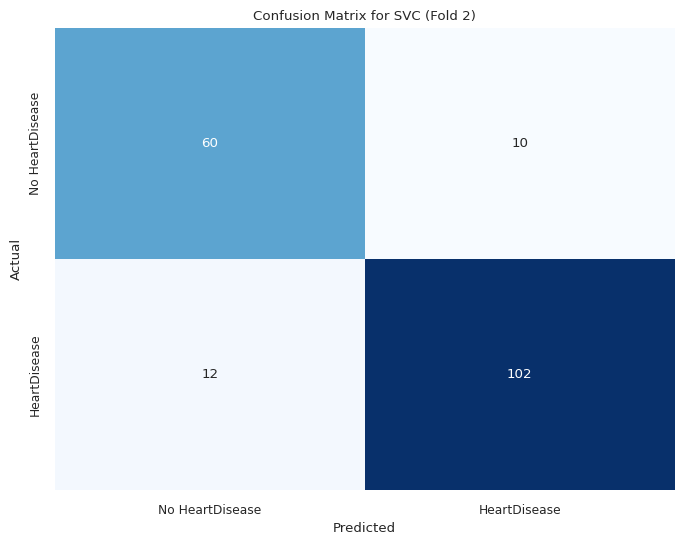

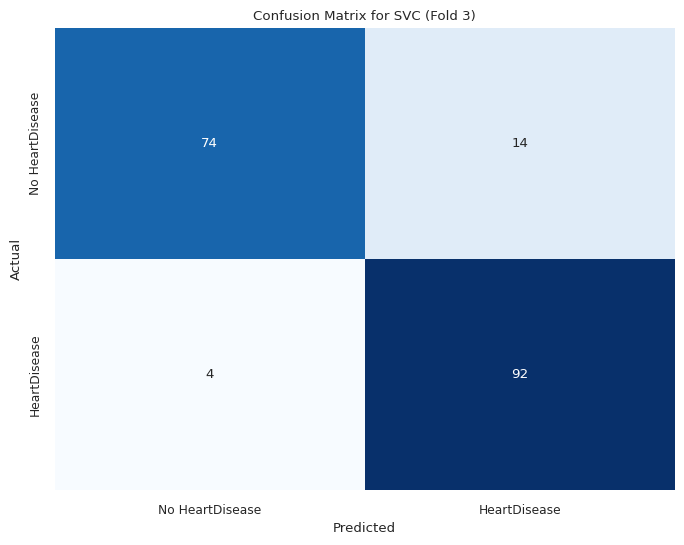

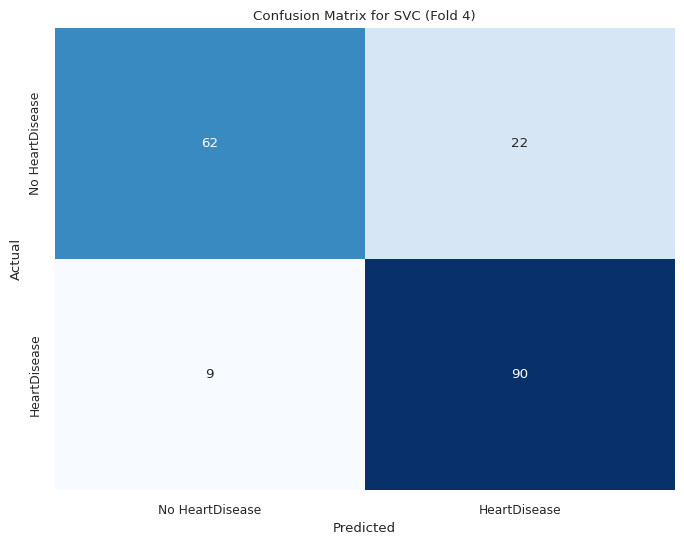

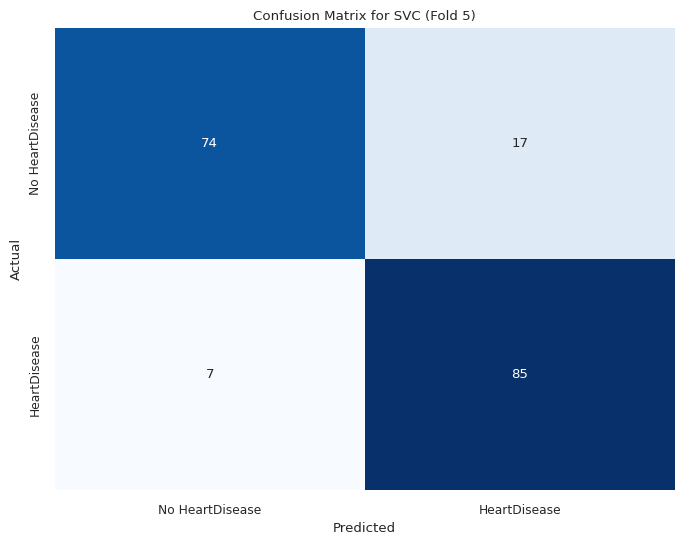

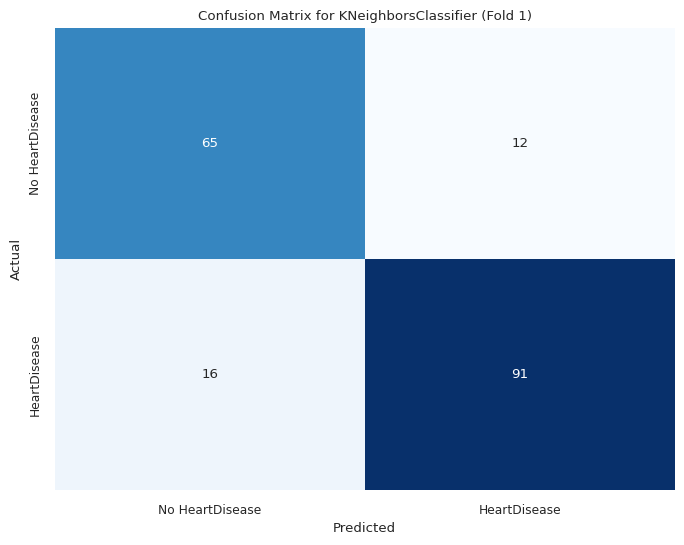

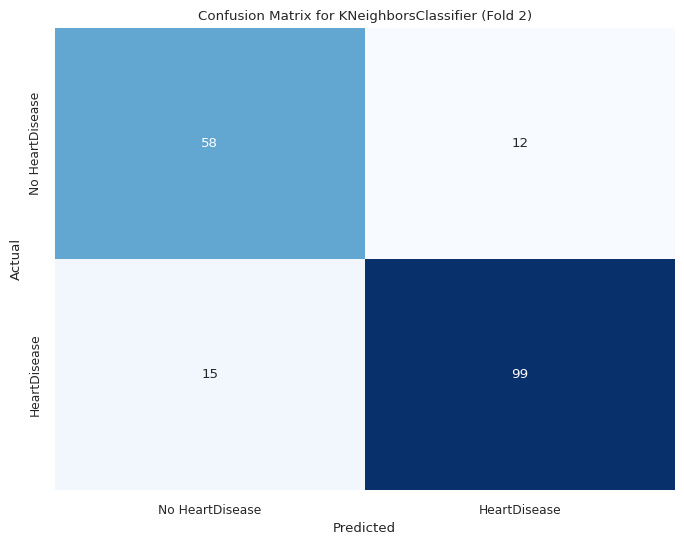

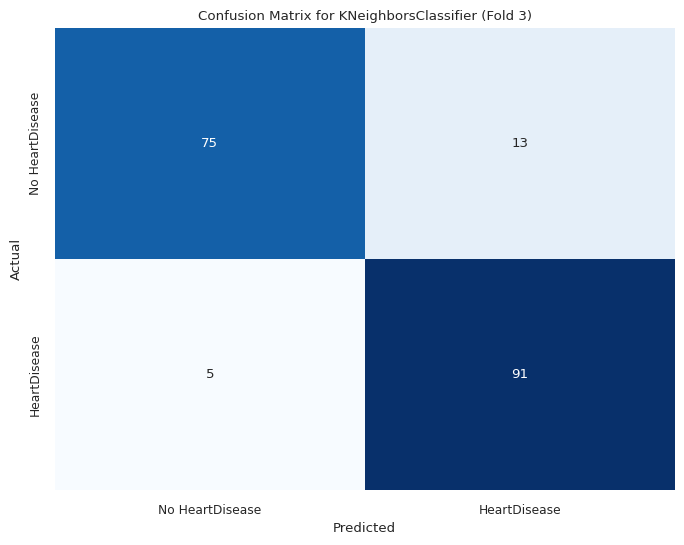

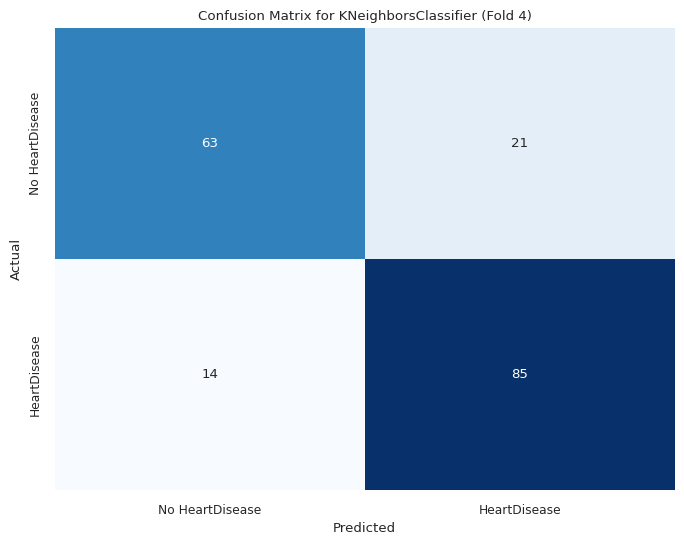

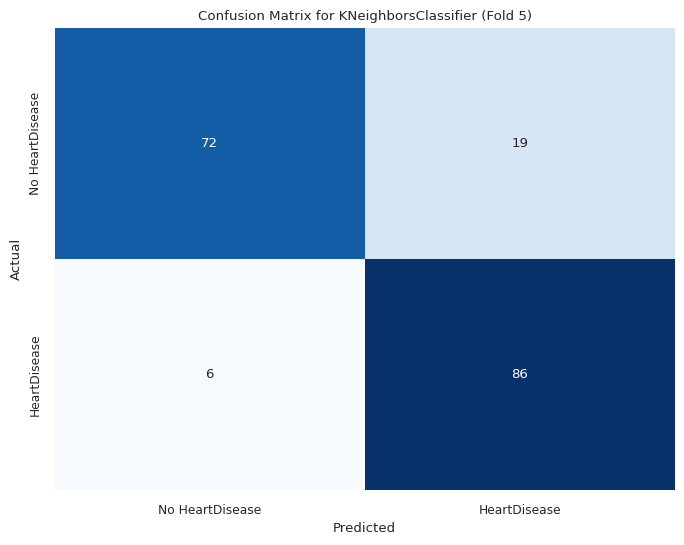

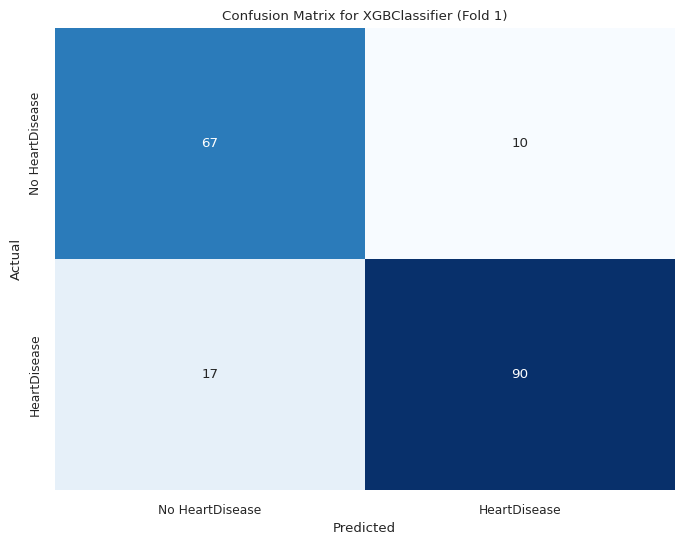

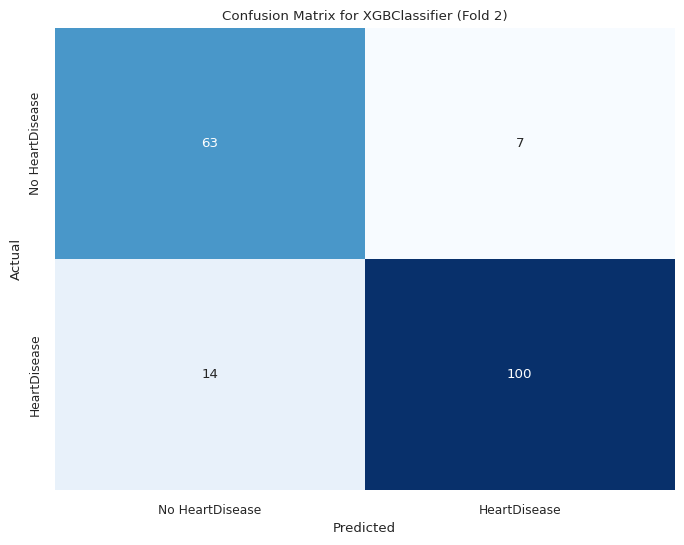

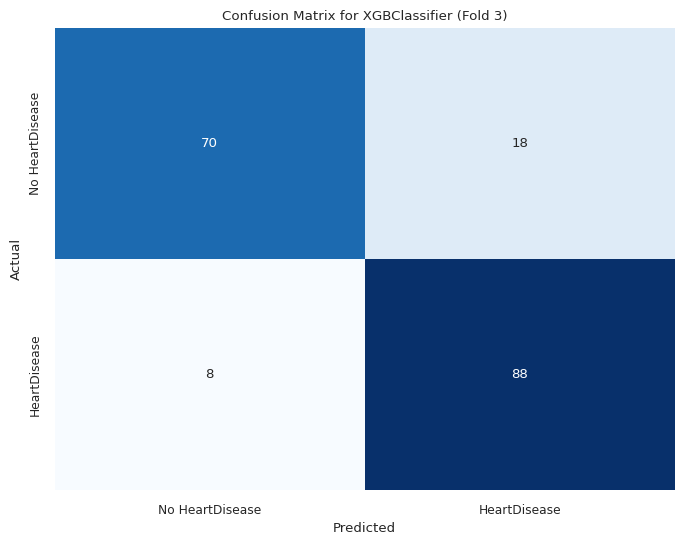

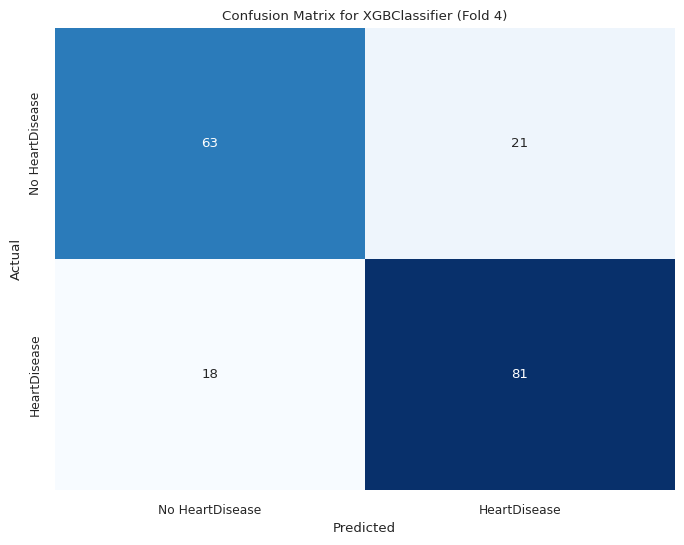

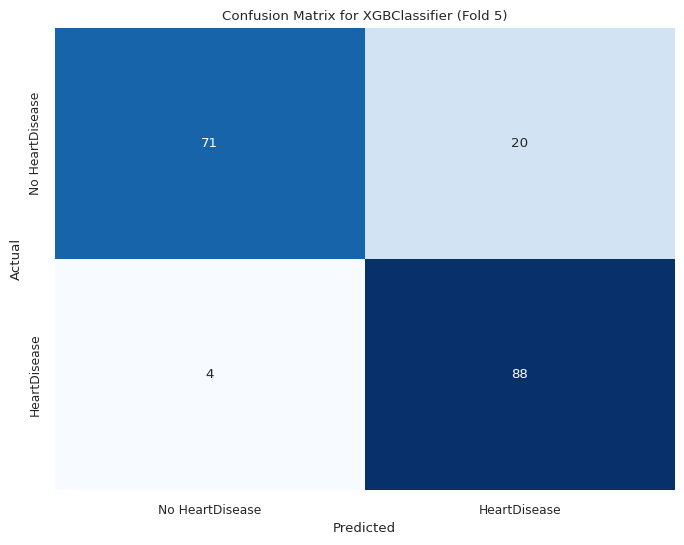

In [43]:
# Iterate through models and perform cross-validation
for model_name, model in models.items():
    for fold, (train_index, test_index) in enumerate(cv.split(X), 1):
        # Split data into train and test sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Define pipeline steps
        pipe_steps = [
            ('preprocessor', preprocessor),
            ('classifier', model)
        ]

        # Create the pipeline
        pipeline = Pipeline(steps=pipe_steps)

        # Fit the pipeline on the resampled training data
        pipeline.fit(X_train, y_train)

        # Evaluate the pipeline on the test data
        y_pred = pipeline.predict(X_test)

        # Store metrics for each fold
        results[model_name]['accuracy'].append(accuracy_score(y_test, y_pred))
        results[model_name]['precision'].append(precision_score(y_test, y_pred))
        results[model_name]['recall'].append(recall_score(y_test, y_pred))
        results[model_name]['f1'].append(f1_score(y_test, y_pred))

        # Print confusion matrix for each fold
        cm = confusion_matrix(y_test, y_pred)
        plot_confusion_matrix(cm, model_name, fold)

In [44]:
# Print the mean scores and choose the best model
best_model = None
best_mean_accuracy = 0

for model_name, metrics in results.items():
    mean_accuracy = np.mean(metrics['accuracy'])
    mean_precision = np.mean(metrics['precision'])
    mean_recall = np.mean(metrics['recall'])
    mean_f1 = np.mean(metrics['f1'])

print(f"\nModel: {model_name}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1-score: {mean_f1:.4f}")

# Choose the best model based on mean accuracy
if mean_accuracy > best_mean_accuracy:
    best_model = model_name
    best_mean_accuracy = mean_accuracy

print(f"\nBest Model: {best_model} with Mean Accuracy: {best_mean_accuracy:.4f}")


Model: XGBClassifier
Mean Accuracy: 0.8507
Mean Precision: 0.8547
Mean Recall: 0.8819
Mean F1-score: 0.8664

Best Model: XGBClassifier with Mean Accuracy: 0.8507


# Model Training & Predicting

In [45]:
# Parameters for XGBClassifier
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5],
    'classifier__min_child_weight': [1, 2, 3],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search to the data
grid_search.fit(X, y)

# Display the best parameters and the corresponding mean cross-validated score
print(f"\nBest Parameters for {best_model}: {grid_search.best_params_}")
print(f"Best Mean Accuracy for {best_model}: {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 729 candidates, totalling 3645 fits

Best Parameters for XGBClassifier: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 100, 'classifier__subsample': 0.9}
Best Mean Accuracy for XGBClassifier: 0.8714


In [46]:
# Set the best hyperparameters
best_hyperparameters = {
    'classifier__colsample_bytree': 0.8,
    'classifier__learning_rate': 0.1,
    'classifier__max_depth': 3,
    'classifier__min_child_weight': 1,
    'classifier__n_estimators': 100,
    'classifier__subsample': 0.9
}
# Update the pipeline with the best hyperparameters
pipeline.set_params(**best_hyperparameters)

# Train the final model on the entire training dataset
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  [0, 3, 4, 7, 9]),
                                                 ('cat', OneHotEncoder(),
                                                  [1, 2, 6, 8, 10])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_me...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, ...))])

In [47]:
y_pred_test = pipeline.predict(X_test)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-score: {test_f1:.4f}")

Test Accuracy: 0.9235
Test Precision: 0.8900
Test Recall: 0.9674
Test F1-score: 0.9271


In [48]:
# Save the trained model using joblib
joblib.dump(pipeline, 'HeartDisease.joblib')


['HeartDisease.joblib']

In [49]:
# Load the saved model
loaded_model = joblib.load('HeartDisease.joblib')

In [50]:
loaded_model.n_features_in_

11

In [51]:
#df1.columns

In [52]:
# Create a NumPy array for the new data point
new_data_point = np.array([[80, 1, 2, 140, 289.0, 140, 1, 140, 1,1.5,0]])

# Make predictions using the loaded model
prediction = loaded_model.predict(new_data_point)

# Display the prediction
print("Prediction:", prediction)


Prediction: [1]
